In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pyotf.otf import HanserPSF, apply_named_aberrations
from pyotf.phaseretrieval import retrieve_phase
from pyotf.display import psf_plot, otf_plot
from pyotf.utils import easy_fft
from dphtools.utils import fftconvolve_fast

In [2]:
psf_params = dict(res=6.5 / 40, zres=0.25, wl=0.585, na=0.95, ni=1.0)

<matplotlib.image.AxesImage object at 0x7fdd2992aeb0>

<Figure size 288x288 with 1 Axes>

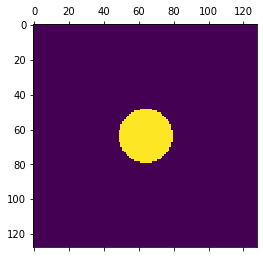

In [3]:
x = (np.arange(128) - 64) * psf_params["res"]
r = np.sqrt(x[None] ** 2 + x[:, None] ** 2)
target = (r < 2.5) * 1.0
plt.matshow(target)

In [4]:
psf = HanserPSF(**psf_params, size=128, zsize=32)
psf = apply_named_aberrations(psf, {"primary spherical": 1.0, "horizontal coma": 1.0})

(
    <Figure size 576x576 with 8 Axes>,
    <mpl_toolkits.axes_grid1.axes_grid.ImageGrid object at 0x7fdd29c67160>
)

<Figure size 576x576 with 8 Axes>

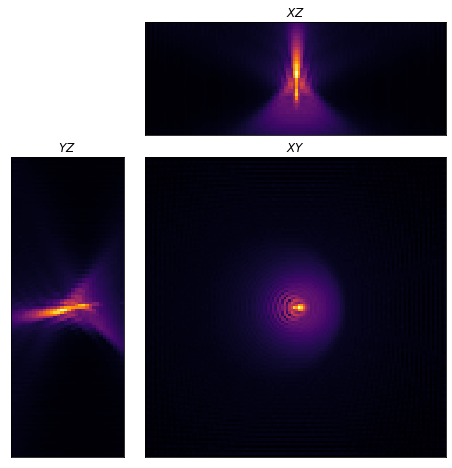

In [5]:
psf_plot(psf.PSFi, zres=psf_params["zres"], res=psf_params["res"])

In [6]:
target_3d = np.zeros_like(psf.PSFi)
target_3d[len(target_3d) // 2] = target

In [7]:
target_convolve = fftconvolve_fast(target_3d, psf.PSFi)

In [8]:
from pyotf.phaseretrieval import *
from pyotf.phaseretrieval import _calc_mse

fft_target = fftn(ifftshift(np.sqrt(target)))


def retrieve_phase(data, params, max_iters=200, pupil_tol=1e-8, mse_tol=1e-8, phase_only=False):
    """Retrieve the phase across the objective's back pupil from an experimentally measured PSF.

    NOTE: If all that is needed is phase, e.g. for adaptive optical correction, then most normal
    ways of estimating the background should be sufficient and you can use the `phase_only`
    keyword. However, if you want to properly model your PSF for something like deconvolution
    then you should be aware that the magnitude estimate is _incredibly_ sensitive to the background
    correction applied to the data prior to running the algorithm, and multiple background
    methods/parameters should be tried.

    Follows: [Hanser, B. M.; Gustafsson, M. G. L.; Agard, D. A.;
    Sedat, J. W. Phase Retrieval for High-Numerical-Aperture Optical Systems.
    Optics Letters 2003, 28 (10), 801.](dx.doi.org/10.1364/OL.28.000801)

    Parameters
    ----------
    data : ndarray (3 dim)
        The experimentally measured PSF of a subdiffractive source
    params : dict
        Parameters to pass to HanserPSF, size and zsize will be automatically
        updated from data.shape
    max_iters : int
        The maximum number of iterations to run, default is 200
    pupil_tol : float
        the tolerance in percent change in change in pupil, default is 1e-8
    mse_tol : float
        the tolerance in percent change for the mean squared error between
        data and simulated data, default is 1e-8
    phase_only : bool
        True means only the phase of the back pupil is retrieved while the
        amplitude is not.

    Returns
    -------
    PR_result : PhaseRetrievalResult
        An object that contains the phase retrieval result
    """
    # make sure data is square
    assert max_iters > 0, "Must have at least one iteration"
    assert data.shape[1] == data.shape[2], "Data is not square in x/y"
    assert data.ndim == 3, "Data doesn't have enough dims"
    # make sure the user hasn't screwed up the params
    params.update(
        dict(vec_corr="none", condition="none", zsize=data.shape[0], size=data.shape[-1])
    )
    # assume that data prep has been handled outside function
    # The field magnitude is the square root of the intensity
    mag = psqrt(data)
    # generate a model from parameters
    model = HanserPSF(**params)
    # generate coordinates
    model._gen_kr()
    # start a list for iteration
    mse = np.zeros(max_iters)
    mse_diff = np.zeros(max_iters)
    pupil_diff = np.zeros(max_iters)
    # generate a pupil to start with
    new_pupil = model._gen_pupil()
    # save it as a mask
    mask = new_pupil.real
    # initialize
    old_mse = old_pupil = np.nan
    # iterate
    for i in range(max_iters):
        # generate new mse and add it to the list
        model.apply_pupil(new_pupil)
        new_mse = _calc_mse(data, model.PSFi)
        mse[i] = new_mse
        if i > 0:
            # calculate the difference in mse to test for convergence
            mse_diff[i] = abs(old_mse - new_mse) / old_mse
            # calculate the difference in pupil
            pupil_diff[i] = (abs(old_pupil - new_pupil) ** 2).mean() / (abs(old_pupil) ** 2).mean()
        else:
            mse_diff[i] = np.nan
            pupil_diff[i] = np.nan
        # check tolerances, how much has the pupil changed, how much has the mse changed
        # and what's the absolute mse
        logger.debug(
            f"Iteration {i}, mse_diff = {mse_diff[i]:.2g}, pupil_diff = {pupil_diff[i]:.2g}"
        )
        if pupil_diff[i] < pupil_tol or mse_diff[i] < mse_tol or mse[i] < mse_tol:
            break
        # update old_mse
        old_mse = new_mse
        # retrieve new pupil
        old_pupil = new_pupil
        # keep phase
        phase = np.angle(model.PSFa.squeeze())
        # replace magnitude with experimentally measured mag
        new_psf = mag * np.exp(1j * phase)
        # generate the new pupils
        new_pupils = fftn(ifftshift(new_psf, axes=(1, 2)), axes=(1, 2))
        # undo defocus and take the mean
        new_pupils /= model._calc_defocus()
        new_pupil = new_pupils.mean(0) * mask * fft_target
        # if phase only discard magnitude info
        if phase_only:
            new_pupil = np.exp(1j * np.angle(new_pupil)) * mask
    else:
        logger.info("Reach max iterations without convergence")
    mse = mse[: i + 1]
    mse_diff = mse_diff[: i + 1]
    pupil_diff = pupil_diff[: i + 1]

    # log final results
    logger.info(
        f"Finished with {i} iterations and rmse={np.sqrt(mse[-1]):.2g}, "
        + f"mse_diff={mse_diff[-1]:.2g}, pupil_diff={pupil_diff[-1]:.2g}"
    )

    # shift mask
    mask = fftshift(mask)
    # shift phase then unwrap and mask
    phase = unwrap_phase(fftshift(np.angle(new_pupil))) * mask
    # shift magnitude
    magnitude = fftshift(abs(new_pupil)) * mask
    return PhaseRetrievalResult(magnitude, phase, mse, pupil_diff, mse_diff, model)

In [9]:
pr_result = retrieve_phase(target_convolve, psf_params.copy(), max_iters=100)

(
    <Figure size 864x360 with 4 Axes>,
    (
        <AxesSubplot:title={'center':'Pupil Phase'}>,
        <AxesSubplot:title={'center':'Pupil Magnitude'}>
    )
)

<Figure size 864x360 with 4 Axes>

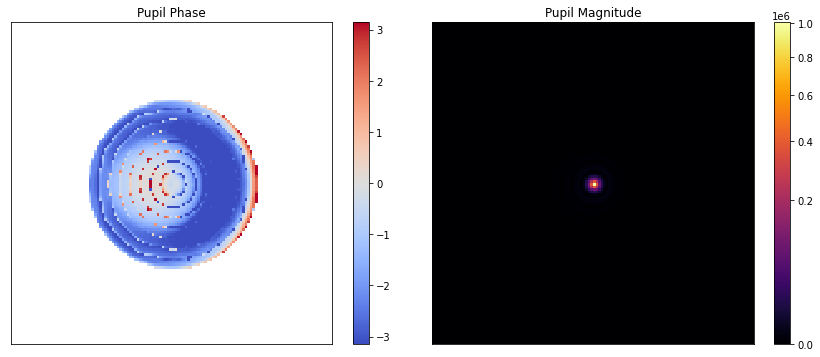

In [10]:
pr_result.plot()

(
    <Figure size 432x432 with 3 Axes>,
    array([<AxesSubplot:title={'center':'Mean Squared Error'}>,
       <AxesSubplot:title={'center':'Relative Change in MSE'}>,
       <AxesSubplot:title={'center':'Relative Change in Pupil'}>],
      dtype=object)
)

<Figure size 432x432 with 3 Axes>

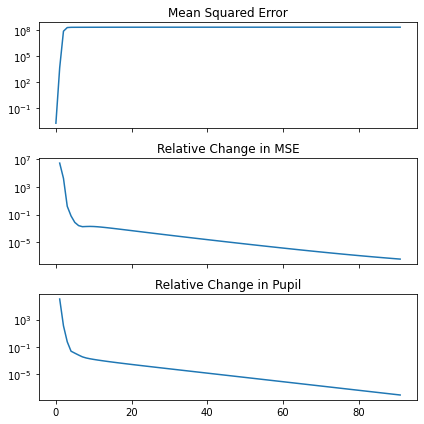

In [11]:
pr_result.plot_convergence()

In [12]:
pr_result.fit_to_zernikes(120)

<pyotf.phaseretrieval.ZernikeDecomposition object at 0x7fdd26361af0>

(
    <Figure size 864x360 with 4 Axes>,
    (
        <AxesSubplot:title={'center':'Pupil Phase'}>,
        <AxesSubplot:title={'center':'Pupil Magnitude'}>
    )
)

<Figure size 864x360 with 4 Axes>

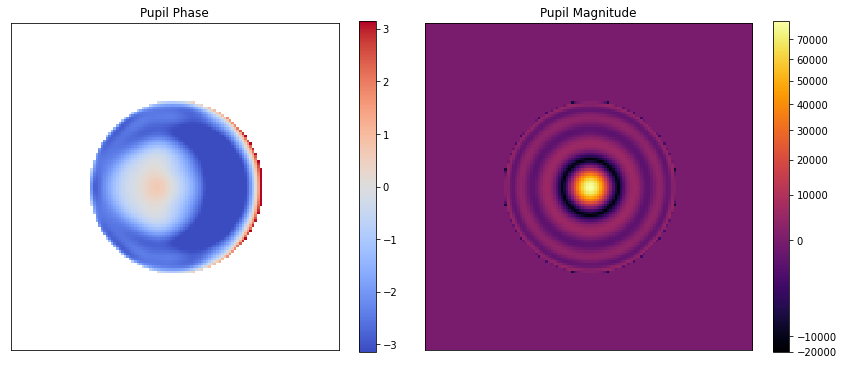

In [13]:
pr_result.zd_result.plot()

(<Figure size 432x432 with 1 Axes>, <AxesSubplot:ylabel='Phase Coefficient'>)

<Figure size 432x432 with 1 Axes>

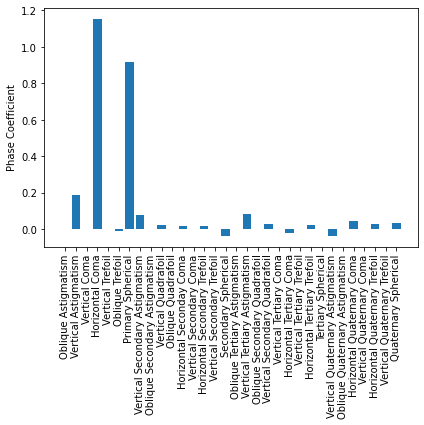

In [14]:
pr_result.zd_result.plot_named_coefs()

(
    <Figure size 576x576 with 8 Axes>,
    <mpl_toolkits.axes_grid1.axes_grid.ImageGrid object at 0x7fdd0e888850>
)

<Figure size 576x576 with 8 Axes>

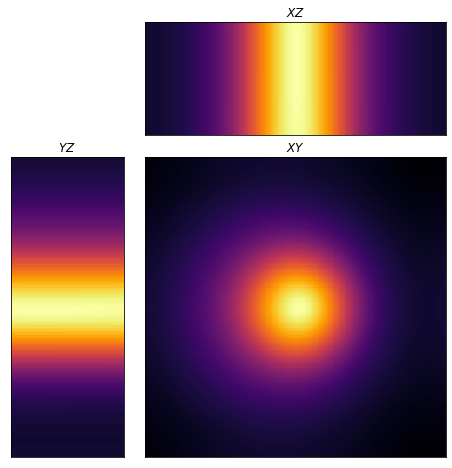

In [15]:
psf_plot(pr_result.generate_psf(), zres=psf_params["zres"], res=psf_params["res"])

(
    <Figure size 576x576 with 8 Axes>,
    <mpl_toolkits.axes_grid1.axes_grid.ImageGrid object at 0x7fdd0ea79a00>
)

<Figure size 576x576 with 8 Axes>

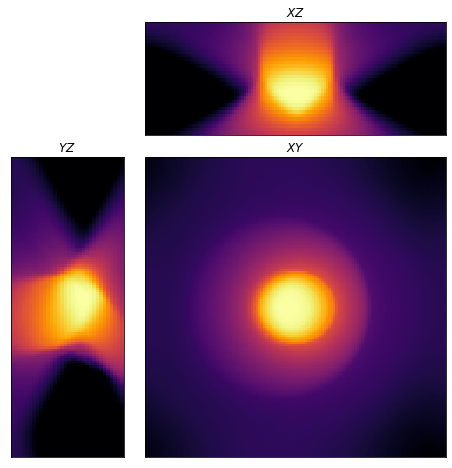

In [16]:
psf_plot(target_convolve, zres=psf_params["zres"], res=psf_params["res"])

(
    <Figure size 576x576 with 8 Axes>,
    <mpl_toolkits.axes_grid1.axes_grid.ImageGrid object at 0x7fdd0f634670>
)

<Figure size 576x576 with 8 Axes>

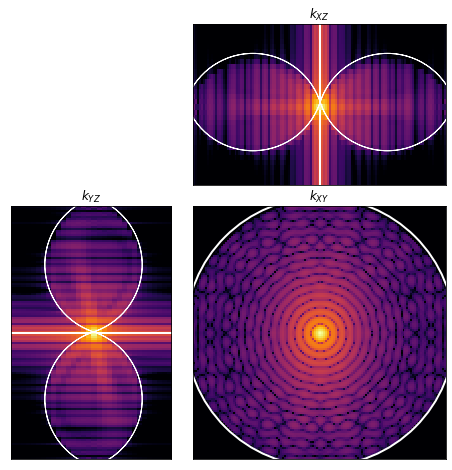

In [17]:
otf_plot(abs(easy_fft(target_convolve)), **psf_params, vmin=1e-2)

(
    <Figure size 576x576 with 8 Axes>,
    <mpl_toolkits.axes_grid1.axes_grid.ImageGrid object at 0x7fdd113816d0>
)

<Figure size 576x576 with 8 Axes>

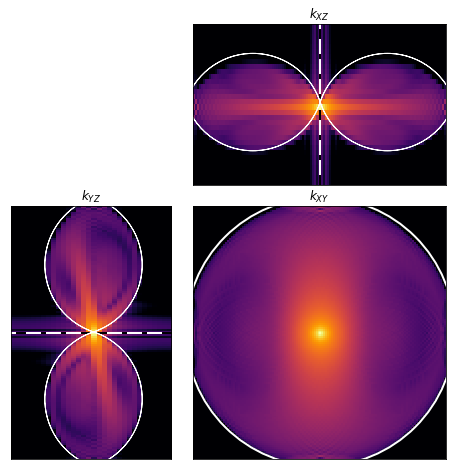

In [18]:
otf_plot(abs(easy_fft(psf.PSFi)), **psf_params, vmin=1e-2)

In [19]:
from pydecon.decon import richardson_lucy
from dphtools.utils import scale

In [20]:
target_convolve_noise = np.random.poisson(scale(target_convolve) * 1000)

(
    <Figure size 576x576 with 8 Axes>,
    <mpl_toolkits.axes_grid1.axes_grid.ImageGrid object at 0x7fdd14f8c130>
)

<Figure size 576x576 with 8 Axes>

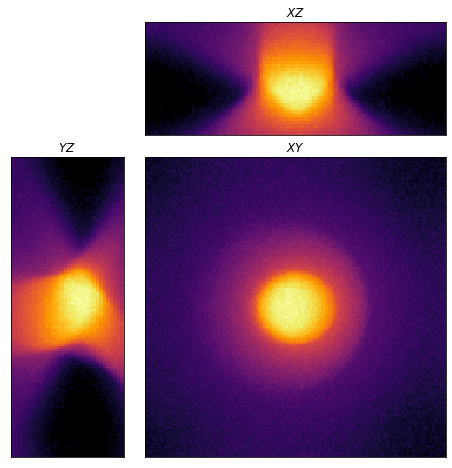

<Figure size 576x576 with 8 Axes>

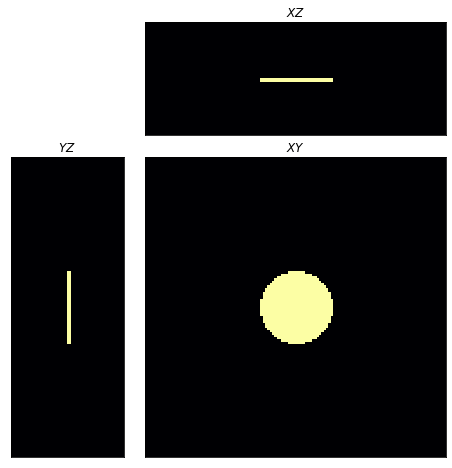

In [21]:
psf_plot(target_convolve_noise, zres=psf_params["zres"], res=psf_params["res"])
psf_plot(target_3d, zres=psf_params["zres"], res=psf_params["res"])

In [32]:
estimated_psf = richardson_lucy(target_convolve_noise, target_3d, 50)

100%|██████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.17it/s]


In [33]:
from pyotf.phaseretrieval import retrieve_phase
from pyotf.utils import prep_data_for_PR

(
    <Figure size 576x576 with 8 Axes>,
    <mpl_toolkits.axes_grid1.axes_grid.ImageGrid object at 0x7fdcfe57b580>
)

<Figure size 576x576 with 8 Axes>

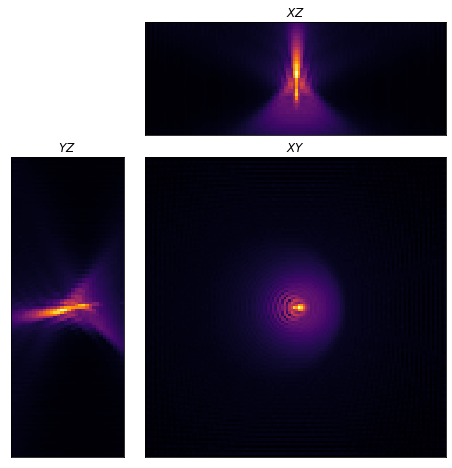

<Figure size 576x576 with 8 Axes>

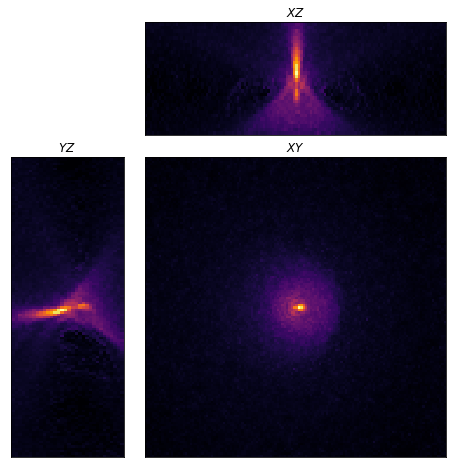

In [34]:
psf_plot(psf.PSFi, zres=psf_params["zres"], res=psf_params["res"])
psf_plot(
    np.fmax(0, prep_data_for_PR(estimated_psf.astype(int), multiplier=0.0)),
    zres=psf_params["zres"],
    res=psf_params["res"],
)

In [35]:
estimated_pr = retrieve_phase(
    np.fmax(0, prep_data_for_PR(estimated_psf.astype(int), multiplier=1.05)), psf_params
)

(
    <Figure size 432x432 with 3 Axes>,
    array([<AxesSubplot:title={'center':'Mean Squared Error'}>,
       <AxesSubplot:title={'center':'Relative Change in MSE'}>,
       <AxesSubplot:title={'center':'Relative Change in Pupil'}>],
      dtype=object)
)

<Figure size 864x360 with 4 Axes>

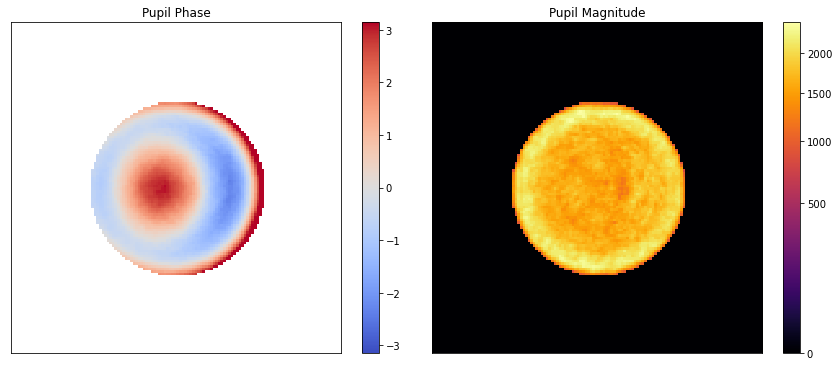

<Figure size 432x432 with 3 Axes>

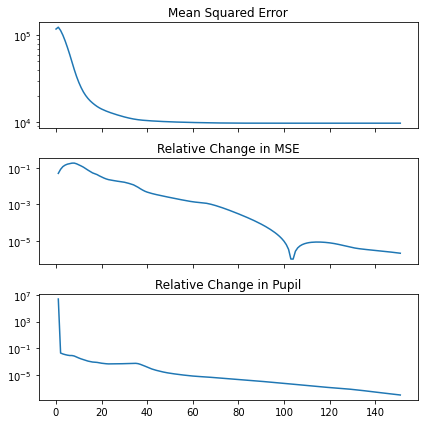

In [36]:
estimated_pr.plot()
estimated_pr.plot_convergence()

In [37]:
estimated_zerns = estimated_pr.fit_to_zernikes(120)

(<Figure size 432x432 with 1 Axes>, <AxesSubplot:ylabel='Phase Coefficient'>)

<Figure size 864x360 with 4 Axes>

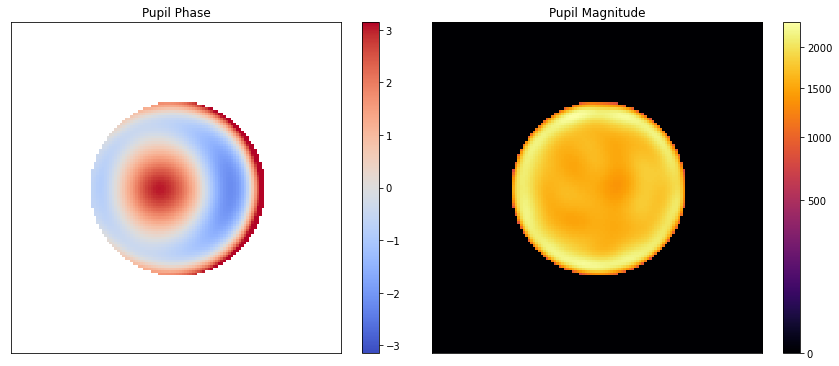

<Figure size 432x432 with 1 Axes>

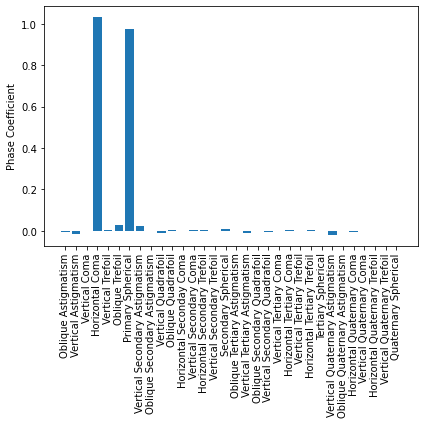

In [38]:
estimated_zerns.plot()
estimated_zerns.plot_named_coefs()